In [1]:
import numpy as np
from scipy.optimize import minimize
import time


# Turbine Diagram

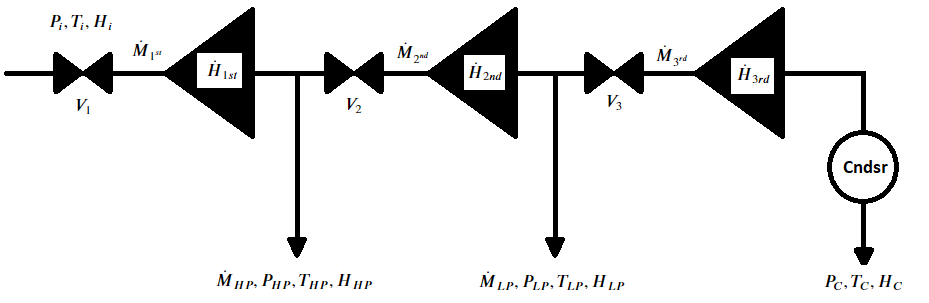

$\dot{M}_{1^{st}},\dot{M}_{2^{nd}},\dot{M}_{3^{rd}},\dot{M}_{HP},\dot{M}_{LP}$ = Steam Mass Flows $[kpph]$

$P_i,P_{HP},P_{LP},P_C$ = Steam Pressures $[psig]$

$T_i,T_{HP},T_{LP},T_C$ = Steam Temperatures $[^o F]$

$H_i,H_{HP},H_{LP},H_{C}$ = Steam Specific Enthalpies $[btu/lb]$

$\dot{H}_{1^{st}},\dot{H}_{2^{nd}},\dot{H}_{3^{rd}}$ = Generator Section Electricity Productions $[MW]$

$V_1, V_2, V_3$ = Valve Position $[ \% - Open]$

## Turbine Model Calculations, Constants and Optimization Functions

In [2]:
'''Min Max Section Flows'''
Smax = np.array([850,475,150],dtype=float)
Smin = np.array([50,50,50], dtype = float)

'''Constants'''
MW_UPPER = 70.
MW_LOWER = 5.
K= 0.000293071 #mBtu/hr -> MW
# Enthalpies for Mi, Mhp, Mlp, Mcond
H = np.array([1440,1235,1165,940], dtype = float)
h_sect = H[0:-1] - H[1:] # section btu/lb

'''Model Functions'''
# Calculate Extraction Flows
def ext_flows(sf):
    return np.array([sf[0]-sf[1],sf[1]-sf[2]])

'''Megawatt Generation'''
def mw_gen(sf):
    return np.dot(sf,h_sect)*K

'''Vectorize PV's (MW, HP extration, LP extraction)'''
def get_pv(sf):
    ef = ext_flows(sf)
    pv = np.array([mw_gen(sf),ef[0],ef[1]])
    return pv

'''Calculate Valve Positions'''
def get_valves(sf):
    vlv = np.array([sf[0]/Smax[0],
                   sf[1]/sf[0],
                    sf[2]/sf[1]])
    return vlv*100

'''Objective Function'''
def error(sf,w,sp):
    # Setpoint Error as Euclidean Distance
    d = (get_pv(sf) - sp)
    e = np.dot(d*d,w)
    return np.sqrt(e)

'''Constraints'''
# Equality Constraints
##### None Needed

# Inequality Constraints (greater than 0)
def ineq1(sf):
    # Upper MW Constraint
    return MW_UPPER - mw_gen(sf)
def ineq2(sf):
    # Lower MW Constraint
    return mw_gen(sf) - MW_LOWER
    
bnds = ((Smin[0],Smax[0]),
        (Smin[1],Smax[1]),
        (Smin[2],Smax[2]))

# SLSQP Constraints
cons = []
cons.append({'type': 'ineq','fun':ineq1,
             'jac': lambda x: np.array([-K*h_sect[0],
                                        -K*h_sect[1],
                                        -K*h_sect[2]])})
cons.append({'type': 'ineq','fun':ineq2,
             'jac': lambda x: np.array([K*h_sect[0],
                                        K*h_sect[1],
                                        K*h_sect[2]])})


## Tuning and Setpoints

In [3]:
'''Setpoints'''
MW_sp = 60
HP_sp = 400
LP_sp = 400
SP = np.array([MW_sp,HP_sp,LP_sp])

'''Weights for Priority Simulation'''
# Speed Weight, HP Weight, LP Weight
priorities = {'HP, LP, MW': np.array([1,100,1], dtype=float),
              'LP, HP, MW': np.array([1,1,100], dtype=float),
              'MW, HP, LP': np.array([10000,10,0.1], dtype=float),
              'MW, LP, HP': np.array([10000,0.1,10], dtype=float)
             }


'''Test Functions'''
# Section Flows for Testing
section_flows = np.array([700, 300, 100])
priority = 'MW, HP, LP'
print(f'Control Priority: {priority}')
print('Weights (MW, HP, LP): ',priorities[priority])
print('Setpoints (MW, HP, LP): ',SP)
print('Valve Positions: ',get_valves(section_flows))
print('PVs :',get_pv(section_flows))
print('Error Function: ',error(section_flows,priorities[priority],SP))
print('====== Constraints =====')
print('Upper MW INEQ: ',ineq1(section_flows))
print('Lower MW INEQ: ', ineq2(section_flows))

Control Priority: MW, HP, LP
Weights (MW, HP, LP):  [1.e+04 1.e+01 1.e-01]
Setpoints (MW, HP, LP):  [ 60 400 400]
Valve Positions:  [82.35294118 42.85714286 33.33333333]
PVs : [ 54.804277 400.       200.      ]
Error Function:  523.4074654867754
====== Constraints =====
Upper MW INEQ:  15.195723000000001
Lower MW INEQ:  49.804277


## Run Optimizer

In [4]:
# initial guess
sf0 = np.array([600, 300, 100])

# arguments for error function
arg = (priorities[priority],SP)

# run opt
start_time = time.time()
sol = minimize(error, sf0, args=arg, method='SLSQP',
              bounds = bnds, constraints = cons,
              options={'disp': True})
end_time = time.time()
print('='*80)
print(f'Control Priority: {priority}')
print('Weights (MW, HP, LP): ',priorities[priority])
print('Max Section Flows: ',Smax)
print('Min Section Flows: ',Smin)
print('Solution (Section Flows): ',sol.x)
print('Error Function Evaluation at Solution: ',error(sol.x,*arg))
print('='*80)
print('Valves % Open: ',get_valves(sol.x))
print('Setpoints (MW, HP, LP): ',SP)
print('PVs (MW, HP, LP):',get_pv(sol.x))
print('='*80)
print("Execution Time: %s sec" % (time.time() - start_time))

Optimization terminated successfully    (Exit mode 0)
            Current function value: 14.0613733376031
            Iterations: 19
            Function evaluations: 78
            Gradient evaluations: 19
Control Priority: MW, HP, LP
Weights (MW, HP, LP):  [1.e+04 1.e+01 1.e-01]
Max Section Flows:  [850. 475. 150.]
Min Section Flows:  [50. 50. 50.]
Solution (Section Flows):  [805.36075421 405.69082889  50.        ]
Error Function Evaluation at Solution:  14.0613733376031
Valves % Open:  [94.74832403 50.37380165 12.32465623]
Setpoints (MW, HP, LP):  [ 60 400 400]
PVs (MW, HP, LP): [ 60.00549966 399.66992532 355.69082889]
Execution Time: 0.03799748420715332 sec
